In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
df = pd.read_csv('../data/all_competitions_combined.csv')

df[df['homecountry_name']=='sweden']

,date,hometeam,awayteam,homecountry,awaycountry,homescore,awayscore,result,competition,homecountry_name,awaycountry_name
8,1990-09-19,Malmö,Beşiktaş,se,tr,3.0,2.0,1.0,champions,sweden,turkey
24,1990-09-19,Norrköping,Köln,se,de,0.0,0.0,0.5,europa,sweden,germany
66,1990-10-03,GAIS,Torpedo Moscow,se,ru,1.0,1.0,0.5,europa,sweden,russia
135,1990-11-07,Malmö,Dresden,se,de,1.0,1.0,0.5,champions,sweden,germany
222,1991-09-18,Göteborg,Flamurtari Vlorë,se,al,0.0,0.0,0.5,champions,sweden,albania
...,...,...,...,...,...,...,...,...,...,...,...
10754,2024-12-12,Malmö,Galatasaray,se,tr,2.0,2.0,0.5,europa,sweden,turkey
10758,2024-12-12,Elfsborg,Qarabağ,se,az,1.0,0.0,1.0,europa,sweden,azerbaijan
10782,2024-12-19,Djurgården,Legia Warsaw,se,pl,3.0,1.0,1.0,conference,sweden,poland
10810,2025-01-23,Malmö,Twente,se,nl,2.0,3.0,0.0,europa,sweden,netherlands


In [4]:
def expected(home, away):
    prob = round( 1 / ( 1 + ( 10 ** ( ( away - home ) / 600 ) ) ) , 2 )

    return prob

def new_elo(home, away, result, I=32):
    change = round( I * ( result - expected( home , away) ) , 2 )

    Eh = home + change
    Ea = away - change

    return Eh, Ea

def get_k(competition):
    if competition == 'champions':
        return 20
    elif competition == 'europa':
        return 10
    else:
        return 5

def calculate_elo(home_country, away_country, result, competition, elo_ratings):

    home_elo = elo_ratings.get(home_country, 1500)
    away_elo = elo_ratings.get(away_country, 1500)

    new_home_elo, new_away_elo = new_elo(home_elo, away_elo, result, I=get_k(competition))

    elo_ratings[home_country] = new_home_elo
    elo_ratings[away_country] = new_away_elo

    return elo_ratings

In [5]:
initial_elo = 1500
elo_ratings = {}
daily_elo_tracker = {}

for index, row in df.iterrows():
    home_country = row['homecountry_name']
    away_country = row['awaycountry_name']
    result = row['result']
    match_date = row['date']
    competition = row['competition']

    elo_ratings = calculate_elo(home_country, away_country, result, competition, elo_ratings)
    
    history_entry = {"date": match_date}
    history_entry.update(elo_ratings)
    daily_elo_tracker[match_date] = history_entry

elo_history = list(daily_elo_tracker.values())
elo_history.sort(key=lambda x: x["date"])

In [6]:
with open('country_coefficients.json', 'w') as f:
    json.dump(elo_history, f, indent=4, default=str)

In [7]:
elo_ranking = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)
elo_df = pd.DataFrame(elo_ranking, columns=['Country', 'Rating'])

print(elo_df)

                   Country   Rating
0                  england  1850.65
1                    spain  1824.15
2                    italy  1756.20
3                  germany  1723.40
4                   france  1710.95
5              netherlands  1696.55
6                 portugal  1687.85
7                  belgium  1608.35
8                 scotland  1532.40
9                   turkey  1519.60
10          czech republic  1508.80
11                 denmark  1505.05
12                 ukraine  1502.50
13                  russia  1494.20
14                 croatia  1491.70
15                 austria  1491.50
16           liechtenstein  1490.90
17                  poland  1488.85
18                 romania  1487.25
19             switzerland  1484.85
20                  kosovo  1484.45
21                  greece  1483.35
22               gibraltar  1483.20
23                   wales  1482.50
24                 armenia  1474.25
25                  norway  1465.05
26  bosnia and herzegovina  

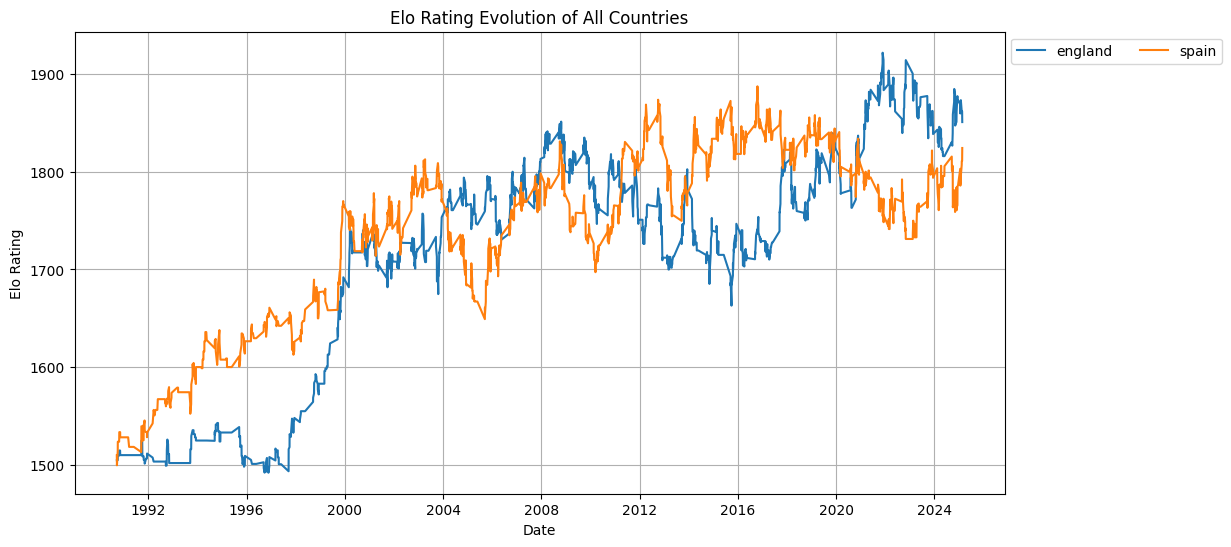

In [8]:
elo_evolution_df = pd.DataFrame(elo_history)
elo_evolution_df["date"] = pd.to_datetime(elo_evolution_df["date"])
elo_evolution_df = elo_evolution_df.sort_values("date")

plt.figure(figsize=(12, 6))

latest_elo_values = elo_evolution_df.iloc[-1].drop("date")
top5 = latest_elo_values.sort_values(ascending=False).iloc[:2].keys()

for country in top5:
    plt.plot(elo_evolution_df["date"], elo_evolution_df[country], label=country)

plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.grid(True)
plt.title("Elo Rating Evolution of All Countries")
plt.show()